In [18]:
import os
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from PIL import Image

import matplotlib.pyplot as plt


import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
from tqdm import tqdm
import numpy as np

In [19]:
# Я бился больше недели с кудой, так и не смог ее поднять на своем компе, на других все нормально работатет(
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.4.1+cpu  Device: cpu


In [20]:
# print(torch.__version__)

In [21]:
class MyDataset(Dataset):
  def __init__(self, root_dir, split="train", transform=None):
    self.root_dir = os.path.join(root_dir, split)
    self.transform = transform
    self.classes = [d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))]
    self.class_to_index = {class_name: index for index, class_name in enumerate(self.classes)}
    self.images = []
    self.labels = []
#     for class_index, class_name in enumerate(self.classes):
#       class_dir = os.path.join(self.root_dir, class_name)
#       for image_name in os.listdir(class_dir):
#         image_path = os.path.join(class_dir, image_name)
#         self.images.append(image_path)
#         self.labels.append(class_index)
    for class_name in self.classes:
       class_dir = os.path.join(self.root_dir, class_name)
       for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        self.images.append(image_path)
        self.labels.append(self.class_to_index[class_name]) #Получаем метку из словаря
    
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_path = self.images[idx]
    image = Image.open(image_path).convert("RGB")
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

In [22]:
# Аугментации
class RandomAugmentations(object):
    def __init__(self, p=0.5, rotate=None, hflip=None, vflip=None, invert=None, solarize=None):
        # Args:
        #     p (float, optional): Вероятность применения аугментации
        #     rotate (int, optional): Диапазон случайного поворота в градусах
        #     hflip (bool, optional): Флаг для случайного горизонтального отражения
        #     vflip (bool, optional): Флаг для случайного вертикального отражения
        #     invert (bool, optional): Флаг для инвертирования цвета
        #     solarize (int, optional): Порог для солнечной аугментации
        self.p = p
        self.rotate = rotate
        self.hflip = hflip
        self.vflip = vflip
        self.invert = invert
        self.solarize = solarize

    def __call__(self, image):
        if random.random() < self.p:
            if self.rotate is not None:
                image = transforms.RandomRotation(degrees=self.rotate)(image)
            if self.hflip:
                image = transforms.RandomHorizontalFlip(p=1)(image)
            if self.vflip:
                image = transforms.RandomVerticalFlip(p=1)(image)
            if self.invert:
                image = transforms.RandomInvert(p=1)(image)
            if self.solarize is not None:
                image = transforms.RandomSolarize(threshold=self.solarize)(image)

        return image

In [23]:
# Создание датасетов
root_dir = "Dataset"
train_dataset = MyDataset(root_dir, split="train", transform=transforms.Compose([
    transforms.Resize(256), #можно было и без этого, но модели обучались более суток, поэтому оставлю, как есть
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    RandomAugmentations(rotate=15, hflip=True, vflip=True, invert=True),
]))

validation_dataset = MyDataset(root_dir, split="valid", transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
]))

test_dataset = MyDataset(root_dir, split="test", transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
]))



In [24]:
# Создание загрузчиков данных
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
num_epochs = 10
learning_rate = 0.001
# Изначально код писал на коллабе, но он падал при долгом обучении. При копировании от туда кода сбились почему-то отступы, исправлять не стал, пока работало

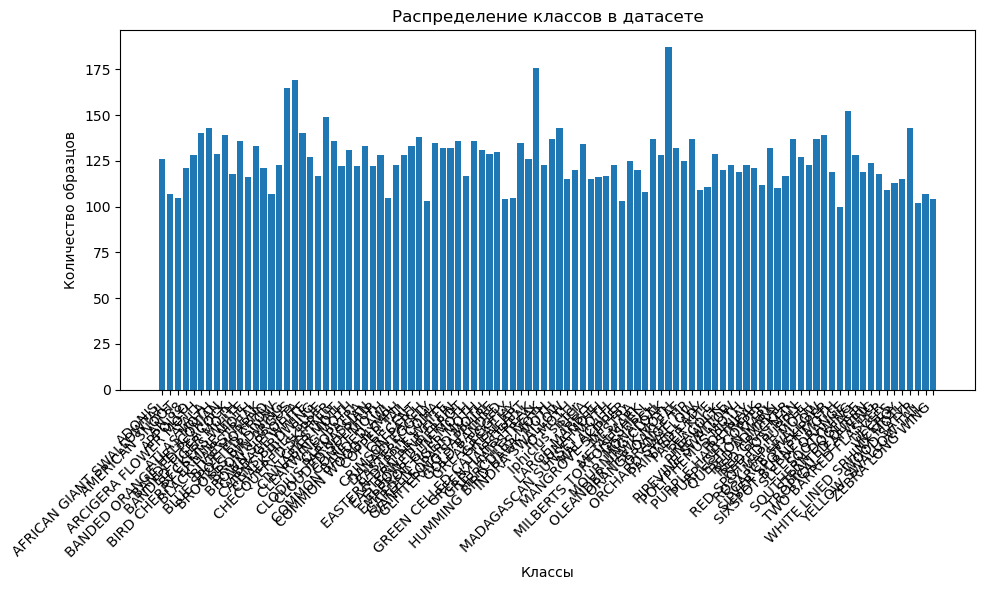

Распределение классов в датасете:
ADONIS: 126
AFRICAN GIANT SWALLOWTAIL: 107
AMERICAN SNOOT: 105
AN 88: 121
APPOLLO: 128
ARCIGERA FLOWER MOTH: 140
ATALA: 143
ATLAS MOTH: 129
BANDED ORANGE HELICONIAN: 139
BANDED PEACOCK: 118
BANDED TIGER MOTH: 136
BECKERS WHITE: 116
BIRD CHERRY ERMINE MOTH: 133
BLACK HAIRSTREAK: 121
BLUE MORPHO: 107
BLUE SPOTTED CROW: 123
BROOKES BIRDWING: 165
BROWN ARGUS: 169
BROWN SIPROETA: 140
CABBAGE WHITE: 127
CAIRNS BIRDWING: 117
CHALK HILL BLUE: 149
CHECQUERED SKIPPER: 136
CHESTNUT: 122
CINNABAR MOTH: 131
CLEARWING MOTH: 122
CLEOPATRA: 133
CLODIUS PARNASSIAN: 122
CLOUDED SULPHUR: 128
COMET MOTH: 105
COMMON BANDED AWL: 123
COMMON WOOD-NYMPH: 128
COPPER TAIL: 133
CRECENT: 138
CRIMSON PATCH: 103
DANAID EGGFLY: 135
EASTERN COMA: 132
EASTERN DAPPLE WHITE: 132
EASTERN PINE ELFIN: 136
ELBOWED PIERROT: 117
EMPEROR GUM MOTH: 136
GARDEN TIGER MOTH: 131
GIANT LEOPARD MOTH: 129
GLITTERING SAPPHIRE: 130
GOLD BANDED: 104
GREAT EGGFLY: 105
GREAT JAY: 135
GREEN CELLED CATTLEHEAR

In [26]:
def analyze_dataset(dataset):
  class_counts = {}
  for _, label in dataset:
    class_name = dataset.classes[label]
    if class_name not in class_counts:
      class_counts[class_name] = 0
    class_counts[class_name] += 1

    # Создание гистограммы
  plt.figure(figsize=(10, 6))
  plt.bar(class_counts.keys(), class_counts.values())
  plt.title("Распределение классов в датасете")
  plt.xlabel("Классы")
  plt.ylabel("Количество образцов")
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()
    
  print("Распределение классов в датасете:")
  for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

  # Проверка дисбаланса
  max_count = max(class_counts.values())
  for class_name, count in class_counts.items():
    if count < max_count / 10:  # Если количество образцов в классе меньше 10% от максимального
        print(f"Класс {class_name} имеет значительный дисбаланс.")

# Анализ датасета
analyze_dataset(train_dataset)

In [27]:
#Есть небольшой дисбаланс в некоторых классах, но не думаю, что это критично. 

In [28]:
# Функция для обучения и оценки модели
def train_and_evaluate_model(model, train_loader, validation_loader):
  model.to(device)
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    loss_epoch = running_loss / len(train_loader)
    accuracy_epoch = correct / total * 100
    train_losses.append(loss_epoch)
    train_accuracies.append(accuracy_epoch)
    print(f"Train Loss: {loss_epoch:.4f}, Train Accuracy: {accuracy_epoch:.2f}%")

    # Валидация
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
      for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

    val_loss /= len(validation_loader)
    val_accuracy = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
  
  return model, train_losses, train_accuracies, val_losses, val_accuracies

In [29]:
!pip install timm
import timm

In [30]:
# Список моделей
models = {   
  "ResNet18": models.resnet18(pretrained=True),
  "VGG16": models.vgg16(pretrained=True),
  "MobileNetV2": models.mobilenet_v2(pretrained=True),
  "ViT": timm.create_model('vit_base_patch16_224', pretrained=True),
  "DeiT": timm.create_model('deit_base_patch16_224', pretrained=True)
}
results = []



E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
E:\Anacond

In [31]:
# Обучение моделей
for model_name, model in models.items():
  # Если используется CNN, изменить последний слой на количество классов
  if model_name in ["VGG16"]:
    # Изменить последний слой в VGG
    num_ftrs = model.classifier[6].in_features # последний линейный слой в classifier 
    model.classifier[6] = nn.Linear(num_ftrs, len(train_dataset.classes))
  elif model_name in ["ResNet18"]:
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
  elif model_name == "MobileNetV2":
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, len(train_dataset.classes))
  elif model_name in ["ViT", "DeiT"]: # Для ViT и DeiT просто добавьте классификацию
    # Предположим, что в ViT линейный слой находится в model.head 
    num_ftrs = model.head.in_features
    model.head = nn.Linear(num_ftrs, len(train_dataset.classes)) 

  print(f"\nНачало тренировки модели: {model_name}")
  trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate_model(model, train_loader, validation_loader)


Начало тренировки модели: ResNet18


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [07:55<00:00,  2.41s/it]


Train Loss: 1.4626, Train Accuracy: 63.42%
Validation Loss: 1.1252, Validation Accuracy: 70.00%


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [07:55<00:00,  2.42s/it]


Train Loss: 0.6104, Train Accuracy: 82.48%
Validation Loss: 1.2207, Validation Accuracy: 67.80%


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [07:36<00:00,  2.32s/it]


Train Loss: 0.4596, Train Accuracy: 86.54%
Validation Loss: 0.6915, Validation Accuracy: 81.20%


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [07:01<00:00,  2.14s/it]


Train Loss: 0.3823, Train Accuracy: 88.49%
Validation Loss: 0.6480, Validation Accuracy: 82.80%


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [07:01<00:00,  2.14s/it]


Train Loss: 0.3057, Train Accuracy: 90.95%
Validation Loss: 0.4120, Validation Accuracy: 87.20%


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [07:01<00:00,  2.14s/it]


Train Loss: 0.2558, Train Accuracy: 92.42%
Validation Loss: 0.3515, Validation Accuracy: 91.00%


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [07:02<00:00,  2.14s/it]


Train Loss: 0.2331, Train Accuracy: 92.73%
Validation Loss: 0.3316, Validation Accuracy: 92.20%


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [07:01<00:00,  2.14s/it]


Train Loss: 0.1866, Train Accuracy: 94.39%
Validation Loss: 0.3310, Validation Accuracy: 92.40%


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [07:00<00:00,  2.14s/it]


Train Loss: 0.1718, Train Accuracy: 94.60%
Validation Loss: 0.5440, Validation Accuracy: 85.00%


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 197/197 [07:01<00:00,  2.14s/it]


Train Loss: 0.1816, Train Accuracy: 94.35%
Validation Loss: 0.4689, Validation Accuracy: 87.00%

Начало тренировки модели: VGG16


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [40:15<00:00, 12.26s/it]


Train Loss: 4.6192, Train Accuracy: 1.32%
Validation Loss: 4.6185, Validation Accuracy: 1.00%


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [40:09<00:00, 12.23s/it]


Train Loss: 4.6120, Train Accuracy: 1.14%
Validation Loss: 4.6140, Validation Accuracy: 1.00%


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [40:05<00:00, 12.21s/it]


Train Loss: 4.6051, Train Accuracy: 1.43%
Validation Loss: 4.6134, Validation Accuracy: 1.00%


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [40:04<00:00, 12.20s/it]


Train Loss: 4.6048, Train Accuracy: 1.25%
Validation Loss: 4.6112, Validation Accuracy: 1.00%


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [40:03<00:00, 12.20s/it]


Train Loss: 4.6040, Train Accuracy: 1.33%
Validation Loss: 4.6112, Validation Accuracy: 1.00%


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [40:07<00:00, 12.22s/it]


Train Loss: 4.6027, Train Accuracy: 1.46%
Validation Loss: 4.6120, Validation Accuracy: 1.00%


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [40:05<00:00, 12.21s/it]


Train Loss: 4.6027, Train Accuracy: 1.47%
Validation Loss: 4.6104, Validation Accuracy: 1.00%


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [40:06<00:00, 12.22s/it]


Train Loss: 4.6020, Train Accuracy: 1.45%
Validation Loss: 4.6106, Validation Accuracy: 1.00%


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [40:01<00:00, 12.19s/it]


Train Loss: 4.6020, Train Accuracy: 1.38%
Validation Loss: 4.6121, Validation Accuracy: 1.00%


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 197/197 [40:01<00:00, 12.19s/it]


Train Loss: 4.6022, Train Accuracy: 1.41%
Validation Loss: 4.6132, Validation Accuracy: 1.00%

Начало тренировки модели: MobileNetV2


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [08:56<00:00,  2.72s/it]


Train Loss: 1.4201, Train Accuracy: 63.92%
Validation Loss: 0.5728, Validation Accuracy: 85.60%


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [08:54<00:00,  2.71s/it]


Train Loss: 0.5746, Train Accuracy: 83.11%
Validation Loss: 0.4358, Validation Accuracy: 85.20%


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [08:54<00:00,  2.71s/it]


Train Loss: 0.4325, Train Accuracy: 87.63%
Validation Loss: 0.3360, Validation Accuracy: 91.20%


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [08:54<00:00,  2.71s/it]


Train Loss: 0.3518, Train Accuracy: 89.45%
Validation Loss: 0.4181, Validation Accuracy: 89.00%


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [08:54<00:00,  2.72s/it]


Train Loss: 0.3286, Train Accuracy: 90.65%
Validation Loss: 0.4570, Validation Accuracy: 88.20%


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [08:54<00:00,  2.71s/it]


Train Loss: 0.2993, Train Accuracy: 90.95%
Validation Loss: 0.4242, Validation Accuracy: 89.60%


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [08:56<00:00,  2.72s/it]


Train Loss: 0.2775, Train Accuracy: 91.50%
Validation Loss: 0.3982, Validation Accuracy: 90.20%


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [08:55<00:00,  2.72s/it]


Train Loss: 0.2661, Train Accuracy: 92.02%
Validation Loss: 0.4108, Validation Accuracy: 90.60%


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [08:54<00:00,  2.71s/it]


Train Loss: 0.2316, Train Accuracy: 92.90%
Validation Loss: 0.2953, Validation Accuracy: 93.00%


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 197/197 [09:07<00:00,  2.78s/it]


Train Loss: 0.2101, Train Accuracy: 93.64%
Validation Loss: 0.3463, Validation Accuracy: 92.60%

Начало тренировки модели: ViT


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [46:42<00:00, 14.23s/it]


Train Loss: 4.7346, Train Accuracy: 1.21%
Validation Loss: 4.6804, Validation Accuracy: 1.20%


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [46:46<00:00, 14.24s/it]


Train Loss: 4.5925, Train Accuracy: 1.77%
Validation Loss: 4.3867, Validation Accuracy: 2.00%


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [46:55<00:00, 14.29s/it]


Train Loss: 4.2433, Train Accuracy: 4.61%
Validation Loss: 3.8268, Validation Accuracy: 8.60%


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [46:59<00:00, 14.31s/it]


Train Loss: 3.6239, Train Accuracy: 13.28%
Validation Loss: 3.1510, Validation Accuracy: 19.80%


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [47:03<00:00, 14.33s/it]


Train Loss: 3.0408, Train Accuracy: 22.86%
Validation Loss: 2.9120, Validation Accuracy: 27.80%


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [47:05<00:00, 14.34s/it]


Train Loss: 2.6883, Train Accuracy: 30.13%
Validation Loss: 2.5606, Validation Accuracy: 29.80%


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [47:13<00:00, 14.39s/it]


Train Loss: 2.4558, Train Accuracy: 35.02%
Validation Loss: 2.2633, Validation Accuracy: 36.20%


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [47:09<00:00, 14.36s/it]


Train Loss: 2.2164, Train Accuracy: 40.13%
Validation Loss: 2.0120, Validation Accuracy: 44.20%


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [47:22<00:00, 14.43s/it]


Train Loss: 2.0528, Train Accuracy: 43.93%
Validation Loss: 1.8784, Validation Accuracy: 49.40%


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 197/197 [49:26<00:00, 15.06s/it]


Train Loss: 1.9258, Train Accuracy: 47.45%
Validation Loss: 1.6491, Validation Accuracy: 52.40%

Начало тренировки модели: DeiT


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [50:23<00:00, 15.35s/it]


Train Loss: 4.6187, Train Accuracy: 1.33%
Validation Loss: 4.5535, Validation Accuracy: 1.80%


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [51:27<00:00, 15.67s/it]


Train Loss: 4.4461, Train Accuracy: 2.48%
Validation Loss: 4.2123, Validation Accuracy: 3.80%


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [55:46<00:00, 16.99s/it]


Train Loss: 3.9740, Train Accuracy: 6.67%
Validation Loss: 3.5808, Validation Accuracy: 12.00%


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [55:04<00:00, 16.77s/it]


Train Loss: 3.2836, Train Accuracy: 17.64%
Validation Loss: 2.6432, Validation Accuracy: 28.00%


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [56:10<00:00, 17.11s/it]


Train Loss: 2.6514, Train Accuracy: 30.13%
Validation Loss: 2.1933, Validation Accuracy: 40.80%


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [52:34<00:00, 16.01s/it]


Train Loss: 2.2846, Train Accuracy: 39.11%
Validation Loss: 2.1417, Validation Accuracy: 45.40%


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [49:11<00:00, 14.98s/it]


Train Loss: 2.0300, Train Accuracy: 44.61%
Validation Loss: 1.7691, Validation Accuracy: 53.60%


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [49:06<00:00, 14.96s/it]


Train Loss: 1.8524, Train Accuracy: 48.77%
Validation Loss: 1.6827, Validation Accuracy: 53.20%


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 197/197 [48:39<00:00, 14.82s/it]


Train Loss: 1.7208, Train Accuracy: 51.83%
Validation Loss: 1.5868, Validation Accuracy: 57.00%


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 197/197 [48:37<00:00, 14.81s/it]


Train Loss: 1.6070, Train Accuracy: 55.11%
Validation Loss: 1.5783, Validation Accuracy: 56.40%


In [32]:
# Расчет ROC AUC для мультиклассовой классификации с OVR.
def multiclass_roc_auc_ovr(y_true, y_pred_proba):
  n_classes = y_true.shape[1]
  auc_scores = []
  for i in range(n_classes):
    for j in range(i + 1, n_classes):
      auc = roc_auc_score(y_true[:, i], y_pred_proba[:, j])
      auc_scores.append(auc)
  mean_auc = np.mean(auc_scores)
  return mean_auc


[]


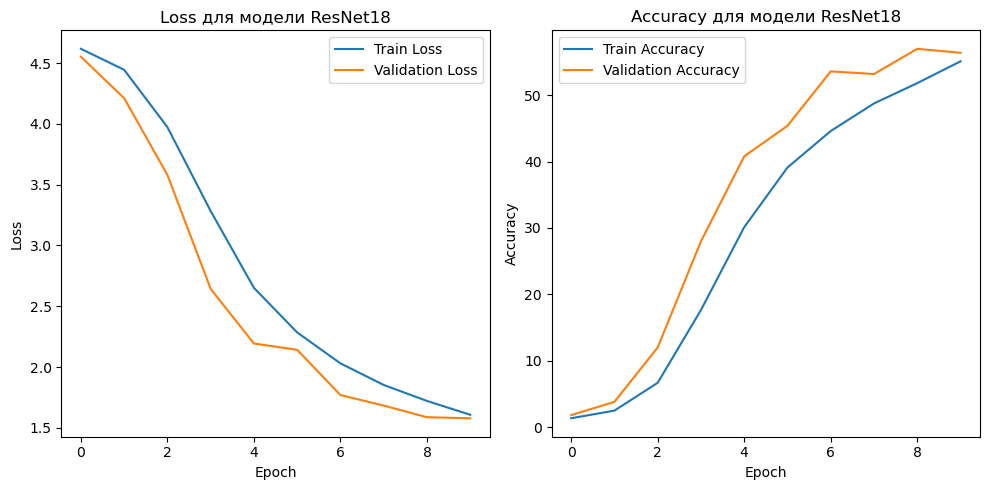

[]


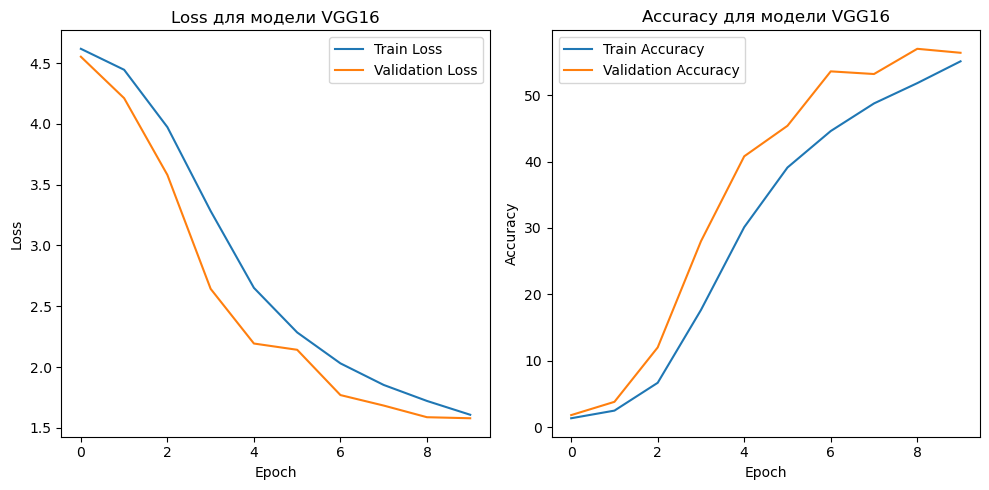

[]


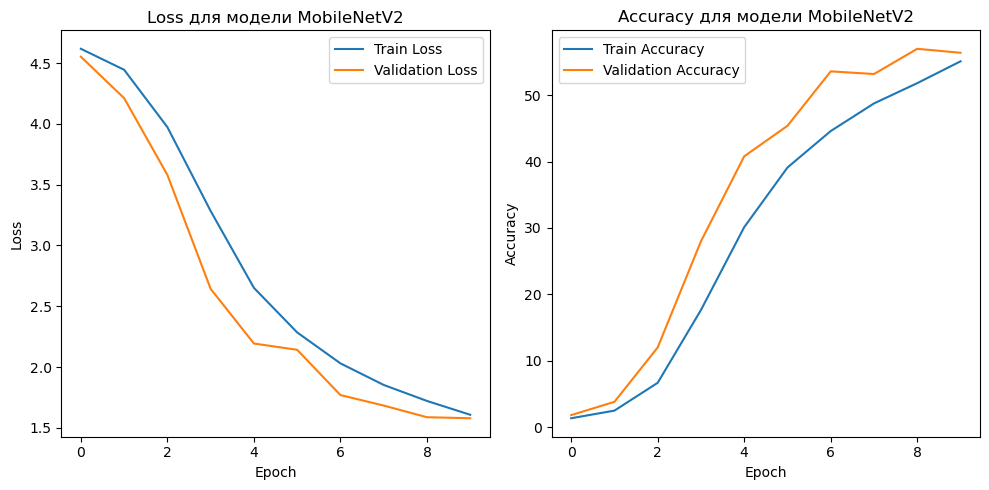

[]


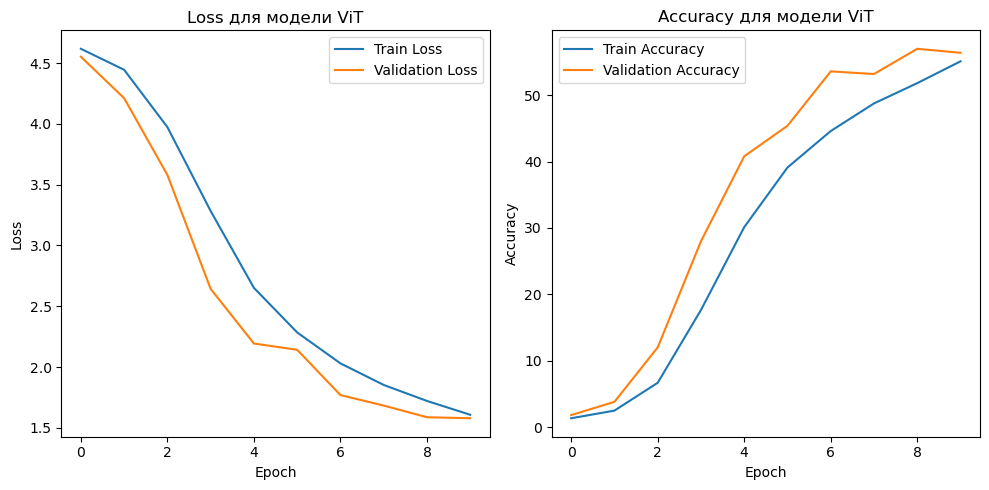

[]


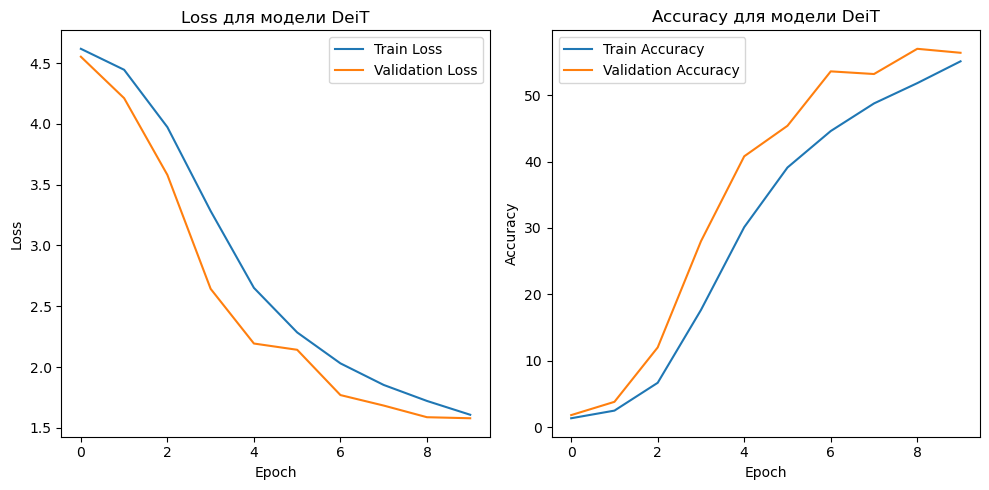

In [33]:
# Оценка на тестовом датасете
for model_name, model in models.items():
 model.eval()
 test_correct = 0
 test_total = 0
 all_labels = []
 all_preds = []
 all_outputs = [] # список для сохранения всех выходов
 print(all_labels)

 with torch.no_grad():
  for images, labels in test_loader:
   images, labels = images.to(device), labels.to(device)
   outputs = model(images)
   _, predicted = torch.max(outputs.data, 1)
   test_total += labels.size(0)
   test_correct += (predicted == labels).sum().item()
   all_labels.extend(labels.cpu().numpy())
   all_preds.extend(predicted.cpu().numpy())
   all_outputs.extend(outputs.cpu().numpy()) # Сохраняем выход модели
#    print(all_labels)

 test_accuracy = test_correct / test_total * 100
 test_f1 = f1_score(all_labels, all_preds, average='weighted')

# Расчет ROC AUC
 test_roc_auc = multiclass_roc_auc_ovr(np.eye(len(train_dataset.classes))[all_labels], 
                    torch.softmax(torch.Tensor(all_outputs), dim=1).numpy())

 results.append({"Model": model_name,
     "Accuracy": test_accuracy,
     "F1 Score": test_f1,
     "ROC AUC": test_roc_auc})
    
 # Графики loss и accuracy
 plt.figure(figsize=(10, 5))
 plt.subplot(1, 2, 1)
 plt.plot(train_losses, label='Train Loss')
 plt.plot(val_losses, label='Validation Loss')
 plt.xlabel('Epoch')
 plt.ylabel('Loss')
 plt.title(f'Loss для модели {model_name}')
 plt.legend()

 plt.subplot(1, 2, 2)
 plt.plot(train_accuracies, label='Train Accuracy')
 plt.plot(val_accuracies, label='Validation Accuracy')
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy')
 plt.title(f'Accuracy для модели {model_name}')
 plt.legend()

 plt.tight_layout()
 plt.show()

In [34]:
# вывод таблицы результатов
results_df = pd.DataFrame(results)
print(results_df)



         Model  Accuracy  F1 Score   ROC AUC
0     ResNet18      89.4  0.889525  0.486747
1        VGG16       1.0  0.000198  0.500000
2  MobileNetV2      94.0  0.936600  0.508444
3          ViT      55.2  0.511893  0.489716
4         DeiT      59.8  0.574738  0.497080


In [36]:
# Вывод
print("\nСравнение моделей:")
print("Пришлось обучать модели 2 раза, тк все логи почему-то сбросились. Примечательно, что я получил разные результаты. Вот что было при первом обучении модели:")
print("Эти результаты показывают, что сверточные сети ResNet18, MobileNetV2 показали себя лучше, чем остальные. Трансформер DeiT также показал неплохие результаты. Исходя из этого нельзя сделать однозначный вывод о том, что лучше: трансформеры или сверточные сети." )
print("При втором обучении модели VGG16 скорее всего просто запомнил все данные, такого при первом обучении не случалось. Модель Deit имела Acc около 85 и лучше F1Score, сейчас она обучилась хуже. Единственная разница между двумя экспериментами заключается в том, что я убрал нормализацию в тестовом даталоудере. Однако не думаю, что именно поэтому получились настолько разные результаты.")


Сравнение моделей:
Пришлось обучать модели 2 раза, тк все логи почему-то сбросились. Примечательно, что я получил разные результаты. Вот что было при первом обучении модели:
Эти результаты показывают, что сверточные сети ResNet18, MobileNetV2 показали себя лучше, чем остальные. Трансформер DeiT также показал неплохие результаты. Исходя из этого нельзя сделать однозначный вывод о том, что лучше: трансформеры или сверточные сети.
При втором обучении модели VGG16 скорее всего просто запомнил все данные, такого при первом обучении не случалось. Модель Deit имела Acc около 85 и лучше F1Score, сейчас она обучилась хуже. Единственная разница между двумя экспериментами заключается в том, что я убрал нормализацию в тестовом даталоудере. Однако не думаю, что именно поэтому получились настолько разные результаты.


In [ ]:
# Чтобы точно ничего не сломать, буду дублировать код ниже для других заданий

In [37]:
# Для ускорения обучения, эпох будет 5
num_epochs = 5
learning_rate = 0.001
results_aug = []

In [38]:
print("Вращение на 15")
train_dataset = MyDataset(root_dir, split="train", transform=transforms.Compose([
  transforms.Resize(256), 
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  RandomAugmentations(rotate=15)
]))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model_name = "ResNet18"
model = models[model_name]
print(f"Модель: {model_name}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate_model(model, train_loader, validation_loader)
model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_preds = []
all_outputs = [] # список для сохранения всех выходов
 
with torch.no_grad():
  for images, labels in test_loader:
   images, labels = images.to(device), labels.to(device)
   outputs = model(images)
   _, predicted = torch.max(outputs.data, 1)
   test_total += labels.size(0)
   test_correct += (predicted == labels).sum().item()
   all_labels.extend(labels.cpu().numpy())
   all_preds.extend(predicted.cpu().numpy())
   all_outputs.extend(outputs.cpu().numpy()) 

test_accuracy = test_correct / test_total * 100
test_f1 = f1_score(all_labels, all_preds, average='weighted')
test_roc_auc = multiclass_roc_auc_ovr(np.eye(len(train_dataset.classes))[all_labels], 
                    torch.softmax(torch.Tensor(all_outputs), dim=1).numpy())

results_aug.append({"Augs": "rotate=15",
          "Accuracy": test_accuracy,
          "F1 Score": test_f1,
          "ROC AUC": test_roc_auc})

Вращение на 15
Модель: ResNet18


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:47<00:00,  2.37s/it]


Train Loss: 0.2224, Train Accuracy: 93.16%
Validation Loss: 0.4948, Validation Accuracy: 88.00%


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:48<00:00,  2.38s/it]


Train Loss: 0.1633, Train Accuracy: 95.05%
Validation Loss: 0.6490, Validation Accuracy: 84.00%


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:48<00:00,  2.38s/it]


Train Loss: 0.1247, Train Accuracy: 95.97%
Validation Loss: 0.3942, Validation Accuracy: 91.20%


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:49<00:00,  2.39s/it]


Train Loss: 0.0905, Train Accuracy: 97.17%
Validation Loss: 0.4236, Validation Accuracy: 90.40%


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:50<00:00,  2.39s/it]


Train Loss: 0.1376, Train Accuracy: 95.82%
Validation Loss: 0.3901, Validation Accuracy: 91.60%


In [39]:
print("Горизонтальное отражение")
train_dataset = MyDataset(root_dir, split="train", transform=transforms.Compose([
  transforms.Resize(256), 
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  RandomAugmentations(hflip=True)
]))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model_name = "ResNet18"
model = models[model_name]
print(f"Модель: {model_name}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate_model(model, train_loader, validation_loader)
model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_preds = []
all_outputs = [] # список для сохранения всех выходов
  
with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      test_total += labels.size(0)
      test_correct += (predicted == labels).sum().item()
      all_labels.extend(labels.cpu().numpy())
      all_preds.extend(predicted.cpu().numpy())
      all_outputs.extend(outputs.cpu().numpy()) 

test_accuracy = test_correct / test_total * 100
test_f1 = f1_score(all_labels, all_preds, average='weighted')
test_roc_auc = multiclass_roc_auc_ovr(np.eye(len(train_dataset.classes))[all_labels], 
                                        torch.softmax(torch.Tensor(all_outputs), dim=1).numpy())

results_aug.append({"Augs": "hflip=True",
                    "Accuracy": test_accuracy,
                    "F1 Score": test_f1,
                    "ROC AUC": test_roc_auc})

Горизонтальное отражение
Модель: ResNet18


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:42<00:00,  2.35s/it]


Train Loss: 0.1816, Train Accuracy: 94.51%
Validation Loss: 0.4482, Validation Accuracy: 89.40%


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:42<00:00,  2.35s/it]


Train Loss: 0.1372, Train Accuracy: 95.69%
Validation Loss: 0.4037, Validation Accuracy: 91.80%


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:43<00:00,  2.35s/it]


Train Loss: 0.1029, Train Accuracy: 96.91%
Validation Loss: 0.2980, Validation Accuracy: 93.40%


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:42<00:00,  2.35s/it]


Train Loss: 0.0929, Train Accuracy: 97.21%
Validation Loss: 0.4879, Validation Accuracy: 89.60%


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:42<00:00,  2.35s/it]


Train Loss: 0.0686, Train Accuracy: 97.74%
Validation Loss: 0.3067, Validation Accuracy: 92.60%


In [40]:
print("Вертикальное отражение")
train_dataset = MyDataset(root_dir, split="train", transform=transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    RandomAugmentations(vflip=True)
]))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model_name = "ResNet18"
model = models[model_name]
print(f"Модель: {model_name}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate_model(model, train_loader, validation_loader)
model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_preds = []
all_outputs = [] # список для сохранения всех выходов
  
with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      test_total += labels.size(0)
      test_correct += (predicted == labels).sum().item()
      all_labels.extend(labels.cpu().numpy())
      all_preds.extend(predicted.cpu().numpy())
      all_outputs.extend(outputs.cpu().numpy()) 

test_accuracy = test_correct / test_total * 100
test_f1 = f1_score(all_labels, all_preds, average='weighted')
test_roc_auc = multiclass_roc_auc_ovr(np.eye(len(train_dataset.classes))[all_labels], 
                                        torch.softmax(torch.Tensor(all_outputs), dim=1).numpy())

results_aug.append({"Augs": "vflip=True",
                    "Accuracy": test_accuracy,
                    "F1 Score": test_f1,
                    "ROC AUC": test_roc_auc})

Вертикальное отражение
Модель: ResNet18


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:46<00:00,  2.37s/it]


Train Loss: 0.1896, Train Accuracy: 94.39%
Validation Loss: 0.4260, Validation Accuracy: 91.20%


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:46<00:00,  2.37s/it]


Train Loss: 0.1307, Train Accuracy: 95.94%
Validation Loss: 0.3898, Validation Accuracy: 91.60%


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:39<00:00,  2.33s/it]


Train Loss: 0.0841, Train Accuracy: 97.32%
Validation Loss: 0.4594, Validation Accuracy: 92.40%


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:58<00:00,  2.43s/it]


Train Loss: 0.0764, Train Accuracy: 97.80%
Validation Loss: 0.4318, Validation Accuracy: 90.80%


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:53<00:00,  2.40s/it]


Train Loss: 0.0702, Train Accuracy: 97.89%
Validation Loss: 0.4027, Validation Accuracy: 94.00%


In [41]:
print("Инвертация цвета")
train_dataset = MyDataset(root_dir, split="train", transform=transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    RandomAugmentations(invert=True)
]))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model_name = "ResNet18"
model = models[model_name]
print(f"Модель: {model_name}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate_model(model, train_loader, validation_loader)
model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_preds = []
all_outputs = [] # список для сохранения всех выходов
  
with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      test_total += labels.size(0)
      test_correct += (predicted == labels).sum().item()
      all_labels.extend(labels.cpu().numpy())
      all_preds.extend(predicted.cpu().numpy())
      all_outputs.extend(outputs.cpu().numpy()) 

test_accuracy = test_correct / test_total * 100
test_f1 = f1_score(all_labels, all_preds, average='weighted')
test_roc_auc = multiclass_roc_auc_ovr(np.eye(len(train_dataset.classes))[all_labels], 
                                        torch.softmax(torch.Tensor(all_outputs), dim=1).numpy())

results_aug.append({"Augs": "invert=True",
                    "Accuracy": test_accuracy,
                    "F1 Score": test_f1,
                    "ROC AUC": test_roc_auc})

Инвертация цвета
Модель: ResNet18


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:55<00:00,  2.41s/it]


Train Loss: 0.0923, Train Accuracy: 97.10%
Validation Loss: 0.3696, Validation Accuracy: 92.60%


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:52<00:00,  2.40s/it]


Train Loss: 0.0682, Train Accuracy: 97.92%
Validation Loss: 0.4443, Validation Accuracy: 91.00%


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:36<00:00,  2.32s/it]


Train Loss: 0.0719, Train Accuracy: 97.64%
Validation Loss: 0.4044, Validation Accuracy: 92.00%


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:47<00:00,  2.37s/it]


Train Loss: 0.0526, Train Accuracy: 98.31%
Validation Loss: 0.4451, Validation Accuracy: 91.40%


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:51<00:00,  2.39s/it]


Train Loss: 0.0330, Train Accuracy: 98.98%
Validation Loss: 0.4301, Validation Accuracy: 92.60%


In [42]:
print("Вращение на 15 + Горизонтальное отражение")
train_dataset = MyDataset(root_dir, split="train", transform=transforms.Compose([
  transforms.Resize(256), 
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  RandomAugmentations(rotate=15, hflip=True)
]))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model_name = "ResNet18"
model = models[model_name]
print(f"Модель: {model_name}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate_model(model, train_loader, validation_loader)
model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_preds = []
all_outputs = [] # список для сохранения всех выходов
 
with torch.no_grad():
  for images, labels in test_loader:
   images, labels = images.to(device), labels.to(device)
   outputs = model(images)
   _, predicted = torch.max(outputs.data, 1)
   test_total += labels.size(0)
   test_correct += (predicted == labels).sum().item()
   all_labels.extend(labels.cpu().numpy())
   all_preds.extend(predicted.cpu().numpy())
   all_outputs.extend(outputs.cpu().numpy()) 

test_accuracy = test_correct / test_total * 100
test_f1 = f1_score(all_labels, all_preds, average='weighted')
test_roc_auc = multiclass_roc_auc_ovr(np.eye(len(train_dataset.classes))[all_labels], 
                    torch.softmax(torch.Tensor(all_outputs), dim=1).numpy())

results_aug.append({"Augs": "rotate=15, hflip=True",
          "Accuracy": test_accuracy,
          "F1 Score": test_f1,
          "ROC AUC": test_roc_auc})

Вращение на 15 + Горизонтальное отражение
Модель: ResNet18


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:52<00:00,  2.40s/it]


Train Loss: 0.1169, Train Accuracy: 96.49%
Validation Loss: 0.4266, Validation Accuracy: 93.20%


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [08:24<00:00,  2.56s/it]


Train Loss: 0.0819, Train Accuracy: 97.55%
Validation Loss: 0.4190, Validation Accuracy: 94.20%


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [08:42<00:00,  2.65s/it]


Train Loss: 0.0918, Train Accuracy: 97.40%
Validation Loss: 0.4294, Validation Accuracy: 92.60%


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [08:45<00:00,  2.67s/it]


Train Loss: 0.0628, Train Accuracy: 98.01%
Validation Loss: 0.4148, Validation Accuracy: 92.40%


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [08:27<00:00,  2.58s/it]


Train Loss: 0.0747, Train Accuracy: 97.75%
Validation Loss: 0.5347, Validation Accuracy: 91.00%


In [43]:
print("Вращение на 15 + Горизонтальное отражение + Инвертация цвета")
train_dataset = MyDataset(root_dir, split="train", transform=transforms.Compose([
  transforms.Resize(256), 
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  RandomAugmentations(rotate=15, hflip=True, invert=True)
]))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model_name = "ResNet18"
model = models[model_name]
print(f"Модель: {model_name}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate_model(model, train_loader, validation_loader)
model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_preds = []
all_outputs = [] # список для сохранения всех выходов
 
with torch.no_grad():
  for images, labels in test_loader:
   images, labels = images.to(device), labels.to(device)
   outputs = model(images)
   _, predicted = torch.max(outputs.data, 1)
   test_total += labels.size(0)
   test_correct += (predicted == labels).sum().item()
   all_labels.extend(labels.cpu().numpy())
   all_preds.extend(predicted.cpu().numpy())
   all_outputs.extend(outputs.cpu().numpy()) 

test_accuracy = test_correct / test_total * 100
test_f1 = f1_score(all_labels, all_preds, average='weighted')
test_roc_auc = multiclass_roc_auc_ovr(np.eye(len(train_dataset.classes))[all_labels], 
                    torch.softmax(torch.Tensor(all_outputs), dim=1).numpy())

results_aug.append({"Augs": "rotate=15, hflip=True, invert=True",
          "Accuracy": test_accuracy,
          "F1 Score": test_f1,
          "ROC AUC": test_roc_auc})

Вращение на 15 + Горизонтальное отражение + Инвертация цвета
Модель: ResNet18


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [08:35<00:00,  2.62s/it]


Train Loss: 0.0932, Train Accuracy: 97.13%
Validation Loss: 0.4642, Validation Accuracy: 92.40%


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [08:45<00:00,  2.67s/it]


Train Loss: 0.0895, Train Accuracy: 97.21%
Validation Loss: 0.4466, Validation Accuracy: 93.00%


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [08:59<00:00,  2.74s/it]


Train Loss: 0.0723, Train Accuracy: 97.82%
Validation Loss: 0.4634, Validation Accuracy: 92.20%


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [08:42<00:00,  2.65s/it]


Train Loss: 0.0615, Train Accuracy: 98.03%
Validation Loss: 0.3855, Validation Accuracy: 93.20%


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [08:26<00:00,  2.57s/it]


Train Loss: 0.0580, Train Accuracy: 98.09%
Validation Loss: 0.3447, Validation Accuracy: 93.60%


In [45]:
print("Вращение на 15 + Горизонтальное отражение + Инвертация цвета + Вертикальное отражение")
train_dataset = MyDataset(root_dir, split="train", transform=transforms.Compose([
  transforms.Resize(256), 
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  RandomAugmentations(rotate=15, hflip=True, vflip=True, invert=True)
]))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model_name = "ResNet18"
model = models[model_name]
print(f"Модель: {model_name}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate_model(model, train_loader, validation_loader)
model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_preds = []
all_outputs = [] # список для сохранения всех выходов
 
with torch.no_grad():
  for images, labels in test_loader:
   images, labels = images.to(device), labels.to(device)
   outputs = model(images)
   _, predicted = torch.max(outputs.data, 1)
   test_total += labels.size(0)
   test_correct += (predicted == labels).sum().item()
   all_labels.extend(labels.cpu().numpy())
   all_preds.extend(predicted.cpu().numpy())
   all_outputs.extend(outputs.cpu().numpy()) 

test_accuracy = test_correct / test_total * 100
test_f1 = f1_score(all_labels, all_preds, average='weighted')
test_roc_auc = multiclass_roc_auc_ovr(np.eye(len(train_dataset.classes))[all_labels], 
                    torch.softmax(torch.Tensor(all_outputs), dim=1).numpy())

results_aug.append({"Augs": "rotate=15, hflip=True, vfip=True, invert=True",
          "Accuracy": test_accuracy,
          "F1 Score": test_f1,
          "ROC AUC": test_roc_auc})

Вращение на 15 + Горизонтальное отражение + Инвертация цвета + Вертикальное отражение
Модель: ResNet18


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [07:54<00:00,  2.41s/it]


Train Loss: 0.1493, Train Accuracy: 95.69%
Validation Loss: 0.4334, Validation Accuracy: 92.40%


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [08:06<00:00,  2.47s/it]


Train Loss: 0.1118, Train Accuracy: 96.68%
Validation Loss: 0.4667, Validation Accuracy: 92.00%


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [08:11<00:00,  2.49s/it]


Train Loss: 0.0852, Train Accuracy: 97.38%
Validation Loss: 0.2982, Validation Accuracy: 93.40%


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [08:10<00:00,  2.49s/it]


Train Loss: 0.0824, Train Accuracy: 97.34%
Validation Loss: 0.4156, Validation Accuracy: 91.80%


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 197/197 [08:07<00:00,  2.48s/it]


Train Loss: 0.0625, Train Accuracy: 97.98%
Validation Loss: 0.3541, Validation Accuracy: 94.60%


In [46]:
# вывод таблицы результатов
results_aug__df = pd.DataFrame(results_aug)
print(results_aug__df)

                                            Augs  Accuracy  F1 Score   ROC AUC
0                                      rotate=15      91.8  0.914721  0.491591
1                                     hflip=True      94.4  0.940904  0.499189
2                                     vflip=True      96.8  0.967848  0.494134
3                                    invert=True      94.2  0.938065  0.498911
4                          rotate=15, hflip=True      91.8  0.913120  0.511800
5             rotate=15, hflip=True, invert=True      93.2  0.928880  0.503984
6  rotate=15, hflip=True, vfip=True, invert=True      95.6  0.955207  0.501725


In [48]:
print("По полученным данным мы можем судить о том, что количество и вид аугментаций не сильно влияет на итоговый результат (при наличии минум одной аугментации). Но если мы боремся за проценты, то наиболее эффективно показали себя аугментация вертикального отражения и комбинация из 4х аугментаций.")

По полученным данным мы можем судить о том, что количество и вид аугментаций не сильно влияет на итоговый результат (при наличии минум одной аугментации). Но если мы боремся за проценты, то наиболее эффективно показали себя аугментация вертикального отражения и комбинация из 4х аугментаций.
